# 1. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cdlib import viz
import os
import sys
import warnings
warnings.filterwarnings('ignore')
# import pandas_profiling
import networkx as nx
from pyvis import network as net
from cdlib import algorithms, viz
from difflib import get_close_matches
from collections import Counter

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'wurlitzer'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer'}


## 1.1 Importing data

In [2]:
# load data from tsv file to a pandas dataframe
movies_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None)

The columns have the following labels:
<br> Movies metadata:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

Character/actors metadata:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

Plot summaries:
1. Wikipedia movie ID
2. Plot summary

In [3]:
#label the columns
movies_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name', 'Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres'] 
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender', 'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']
plot_summaries.columns = ['Wikipedia_movie_ID', 'Plot_summary']

## 1.2 Visualizing row data

In [4]:
movies_metadata.sample(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
17990,828218,/m/03ffcz,The Singing Detective,1986,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia"", ""/m/02jx1"": ""England""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster..."
27056,1407207,/m/04_285,Game Over: Kasparov and the Machine,2003-09-05,NaN,85.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada"", ""/m/07ssc"": ""United Ki...","{""/m/0hj3n07"": ""Culture & Society"", ""/m/0hj3mz..."
29962,27301847,/m/0hr8lq4,Death and Cremation,NaN,NaN,86.0,{},{},"{""/m/01jfsb"": ""Thriller"", ""/m/0219x_"": ""Indie""}"


In [5]:
character_metadata.sample(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
109723,811907,/m/03dq65,1988-01-07,NaN,1967-01-31,F,NaN,NaN,Irene Wan,20.0,/m/0bvc4qj,NaN,/m/0flmyw
328700,958640,/m/03tdy4,1977-02-25,Paul Whitley,1926-03-18,M,1.905,NaN,Peter Graves,50.0,/m/0g3yrpn,/m/0h5m1xd,/m/02j4sk
35372,18646902,/m/04gqyj8,NaN,NaN,1950-10-12,M,1.800,NaN,Takeshi Kaga,NaN,/m/0gw4g9f,NaN,/m/028phv


In [6]:
plot_summaries.sample(3)

,Wikipedia_movie_ID,Plot_summary
15632,6819522,"The story centers around Brian Anderson , a so..."
25491,6224371,"The story takes place in old Mexico, where a m..."
3780,15359592,The film takes one year after the events of th...


# 2. Understanding and cleaning data

## 2.1 Exploring raw data

We use the pandas_profiling librarie to get a first rapid overview of the data. It gives many information like value repartition, correlations and missing values.
<br>It ouptput the `character_metadata_report.html` and `movies_metadata_report.html` which can be found in the repo and doesn't requierd to re-run every time so we comment it.

In [7]:
# # profile the movies metadata dataframe
# movies_metadata.profile_report(title='Movies Metadata Report')
# # show the profile report
# movies_metadata.profile_report()

In [8]:
# # profile the character metadata dataframe
# character_metadata.profile_report(title='Character Metadata Report')
# # show the profile report
# character_metadata.profile_report()

We remark that for movies the `Movie_box_office_revenue`, `Movie_runtime` columns have some missing values and we face the same problems with those columns `Character_name`, `Actor_date_of_birth`, `Actor_height_(in_meters)`, `Actor_ethnicity` in the actor dataset. We'll probably not use most of them except for the boxoffice revenue and the ethnicity who could be interresting but will need some scarping to add missing values.

## 2.2 Cleaning the data

We aim to create a network between actors as nodes and movies as edges. Therfore we need to match those two different dataframes. The `Wikipedia_movie_ID` and `Freebase_movie_ID` are perfect for that as they have no missing values. <br>
Furthermore we choose to use `Actor_name` as identifier for the actors as it is more understandable than the Freebase ID. As we will use it as identifier we will need to assure us that each Actor_name relates to a unique actor. And we also want to check if there is some typos in the actor names.

In [9]:
# firstly filter actors_name
character_metadata = character_metadata.dropna(subset=['Actor_name'])

# create a dataframe referencing every actor_names
actors_unique = character_metadata.drop_duplicates('Actor_name')

Let's start to see if actor names link to a unique ID. This is necessary if we want to use it as identifier. <br>
__Note:__ The following tests take a lot of times and are just there to see if somethings is wrong, once we know it we didn't need to re-run it so we commented it.

In [10]:
# # check if every same actor_names refer to same actor_id
# for a in actors_unique.Actor_name:
#     same_name = character_metadata.query("`Actor_name` == @a")
#     if same_name.Freebase_actor_ID.nunique() > 1:
#         print(a, same_name.Freebase_actor_ID.unique())

We remark that some actors have the same `Actor_name` ! 
> This mean we can't us it as an identifier as we planned but we'll need to use the Freebase ID instead.

However we would like to use the actor names and can't ignore the typo question. We tried a naive way with the `get_close_matches` function which return us similar strings. 
But we have ~100'000 different names which take a lot of time but also gives way to much matches. The problem is that we should check them by hand which isn't possible. <br>
Therefore we won't use the first method on the full dataset but later on after having created a smaller dataset we'll use.

In [11]:
# # for n in actors_unique.Actor_name:
#     if type(n) == t:
#         match = get_close_matches(n,actors_unique.Actor_name , cutoff=0.9)
#         if len(match) > 1:
#             print(match)

We thought to compare if a an id refer to more than one name. As expected it isn't the case, certainly because names and id were scrapped in the same pages.

In [12]:
# create a dataframe referencing every unique id
# actor_id_unique = character_metadata.drop_duplicates('Freebase_actor_ID')
# for i in actor_id_unique.Freebase_actor_ID:
#     same_name = character_metadata.query("`Freebase_actor_ID` == @i")
#     if same_name.Actor_name.nunique() > 1:
#         print("Freebase id: ", i, " | names: ", same_name.unique())

In [13]:
# filter characters metadata dataframe to keep only the characters where the character name and actor name are not null
characters_before_filter = character_metadata.shape[0]
character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull()]
#character_metadata = character_metadata[character_metadata['Freebase_actor_ID'].notnull() & character_metadata['Actor_name'].notnull()]
# show how many characters were originally in the dataframe, how many were removed and how many are left
print('Number of characters before filter: ', characters_before_filter)
print('Number of characters after filter: ', character_metadata.shape[0])
print('Number of characters removed: ', characters_before_filter - character_metadata.shape[0])

Number of characters before filter:  449441
Number of characters after filter:  449441
Number of characters removed:  0


<div class="alert alert-block alert-danger">
    <b>
        Check utility of filtering actors
        <br>for movies: normal to have > and not >= ?4
        <br> Check character filtering , should we also filter null actor names ? ( 1228 character filtered when we filter by actor names 
    </b>
</div>

We need movies that have at least 2 actors to connect the nodes.

In [14]:
# list the characters of each movie in a list and the actors of each movie in a list
actors = character_metadata.groupby('Wikipedia_movie_ID')['Actor_name'].apply(list).reset_index().rename(columns={'Actor_name': 'Actors_names'})
# count the actors of each movie
actors['Number_of_actors'] = actors['Actors_names'].apply(lambda x: len(x))
# filter the actors dataframe to keep only the movies with more than 2 actors
actors = actors[actors['Number_of_actors'] > 2].reset_index(drop=True)
# show the number of movies before and after the filter and how many movies were removed
print('Number of movies before filter: ', character_metadata['Wikipedia_movie_ID'].nunique())
print('Number of movies after filter: ', actors.shape[0])
print('Number of movies removed: ', character_metadata['Wikipedia_movie_ID'].nunique() - actors.shape[0])


Number of movies before filter:  64258
Number of movies after filter:  48770
Number of movies removed:  15488


## 2.3 Further exploration of cleaned data

Now that we have drop the data that won't be usefull we can start analysing it.

In [15]:
# Firstly print the new dataframe merging movies and actors
actors

,Wikipedia_movie_ID,Actors_names,Number_of_actors
0,330,"[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...",4
1,3217,"[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...",14
2,3333,"[Lillian Gish, Henry B. Walthall, Mae Marsh, S...",14
3,3746,"[William Sanderson, Harrison Ford, Rutger Haue...",15
4,3837,"[Jack Starrett, Slim Pickens, Dave Sharpe, Lia...",20
...,...,...,...
48765,37322106,"[Katrina Kaif, Shahrukh Khan, Anushka Sharma]",3
48766,37373877,"[Gabrielle Anwar, Traci Lords, Dina Meyer, Geo...",7
48767,37476824,"[Zayed Khan, Raveena Tandon, Amitabh Bachchan,...",10
48768,37478048,"[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...",4


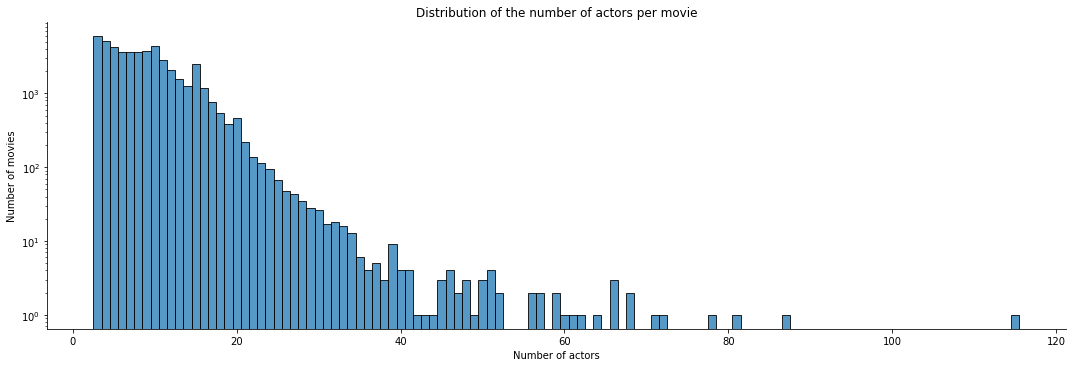

In [16]:
plot = sns.displot(actors['Wikipedia_movie_ID'], x = actors['Number_of_actors'],
                   log=True, discrete=True, aspect = 3)
plot = plot.set(title = 'Distribution of the number of actors per movie', 
               xlabel = 'Number of actors',
               ylabel = 'Number of movies')

# 3. Creating a network of actors

It's now time to creat a first network

## 3.1 Processing the data

In [17]:
# one actor per line in the new dataframe
actors_new_meta = actors.merge(character_metadata[['Character_name', 'Actor_name','Freebase_actor_ID','Wikipedia_movie_ID']], on='Wikipedia_movie_ID', how='inner')

In [18]:
actors_new_meta.sample(3)

,Wikipedia_movie_ID,Actors_names,Number_of_actors,Character_name,Actor_name,Freebase_actor_ID
407990,32490636,"[Ben Winchell, Chris Zylka, Lindsey Shaw, Cass...",15,Lisa,Lindsey Shaw,/m/05ln32
200016,10057067,"[Mai Zetterling, George Cole, Donald Wolfit, A...",7,NaN,Richard Widmark,/m/02x08c
105672,3544709,"[Sarah Jessica Parker, Teri Garr, Peter Weller...",6,Lee,Robert Downey Jr.,/m/016z2j


In [19]:
# dataframe with pairs of actors and the number of movies they acted in together
# the dataframe to merge contains all the actors_new_meta dataframe except the actors_names column
to_merge = actors_new_meta.drop('Actors_names', axis=1)
actors_pairs = to_merge.merge(to_merge, on=['Wikipedia_movie_ID', 'Number_of_actors'], how='inner')
# filter the dataframe to keep only the pairs where the actor names are different
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] != actors_pairs['Actor_name_y']]
actors_pairs = actors_pairs[actors_pairs['Freebase_actor_ID_x'] != actors_pairs['Freebase_actor_ID_y']]
# filter the dataframe to keep only the pairs that are not interchangeable (actor1, actor2) and (actor2, actor1)
actors_pairs = actors_pairs[actors_pairs['Actor_name_x'] < actors_pairs['Actor_name_y']]
actors_pairs = actors_pairs[actors_pairs['Freebase_actor_ID_x'] < actors_pairs['Freebase_actor_ID_y']]

In [20]:
# for each pair make a new column with the list of movies they acted in together
actors_pairs_common_movies = actors_pairs.groupby(['Actor_name_x', 'Actor_name_y','Freebase_actor_ID_x','Freebase_actor_ID_y'])['Wikipedia_movie_ID'].apply(list).reset_index().rename(columns={'Wikipedia_movie_ID': 'Common_movies'})
# remove the duplicates in the movies list
actors_pairs_common_movies['Common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: list(set(x)))

In [21]:
# number of common movies between each pair of actors
actors_pairs_common_movies['Number_of_common_movies'] = actors_pairs_common_movies['Common_movies'].apply(lambda x: len(x))

In [22]:
# filter the dataframe to keep only the pairs that acted in more than 2 movies together
actors_pairs_common_movies_filtered = actors_pairs_common_movies[actors_pairs_common_movies['Number_of_common_movies'] > 2]

In [23]:
actors_pairs_common_movies_filtered.sample(3)

,Actor_name_x,Actor_name_y,Freebase_actor_ID_x,Freebase_actor_ID_y,Common_movies,Number_of_common_movies
397347,Daws Butler,George O'Hanlon,/m/0223g8,/m/05dyjh,"[13638200, 11419179, 1888983]",3
153663,Bam Margera,Missy Rothstein,/m/02m3sd,/m/03d39cl,"[21951280, 3260822, 13727751]",3
512723,Felissa Rose,Joe Estevez,/m/04cfxp,/m/06gv55,"[6650513, 28035306, 28041484]",3


## 3.2 Creating the network

There are many ways to create networks, a really common one is the networkx library. It offers lots of tools and we can easily find documentation on the web.

In [24]:
# create a non directed graph from the dataframe
G = nx.from_pandas_edgelist(actors_pairs_common_movies_filtered, source='Freebase_actor_ID_x', target='Freebase_actor_ID_y', edge_attr='Number_of_common_movies')
# show the number of nodes and edges in the graph
print('Number of nodes: ', G.number_of_nodes())
print('Number of edges: ', G.number_of_edges())

Number of nodes:  6320
Number of edges:  12728


Now that we have the network we'll need to analyse it. The first step is to create subgroup using the louvain algorithm.

In [25]:
# make partitions of the graph 
coms = algorithms.louvain(G, weight='Number_of_common_movies')

# make subgraphs from the partitions
subgraphs = [G.subgraph(c) for c in coms.communities]
# show the number of subgraphs
print('Number of communities: ', len(subgraphs))

Number of communities:  632


In [26]:
# show the number of nodes in each subgraph and the average weight of the edges in each subgraph
for i, subgraph in enumerate(subgraphs):
    print('community ', i + 1, ' number of actors: ', subgraph.number_of_nodes())
    print('community ', i + 1, ' average numbers of movies between actors: ', subgraph.size(weight='Number_of_common_movies') / subgraph.number_of_edges())

community  1  number of actors:  598
community  1  average numbers of movies between actors:  4.4328180737217595
community  2  number of actors:  392
community  2  average numbers of movies between actors:  3.7963302752293577
community  3  number of actors:  378
community  3  average numbers of movies between actors:  3.525
community  4  number of actors:  371
community  4  average numbers of movies between actors:  3.3891472868217054
community  5  number of actors:  309
community  5  average numbers of movies between actors:  4.926548672566372
community  6  number of actors:  266
community  6  average numbers of movies between actors:  3.606837606837607
community  7  number of actors:  243
community  7  average numbers of movies between actors:  4.207161125319693
community  8  number of actors:  225
community  8  average numbers of movies between actors:  4.861386138613861
community  9  number of actors:  199
community  9  average numbers of movies between actors:  4.0212765957446805


## 3.3 Vizualising the network

Let's start the funny part with a basic visualization.

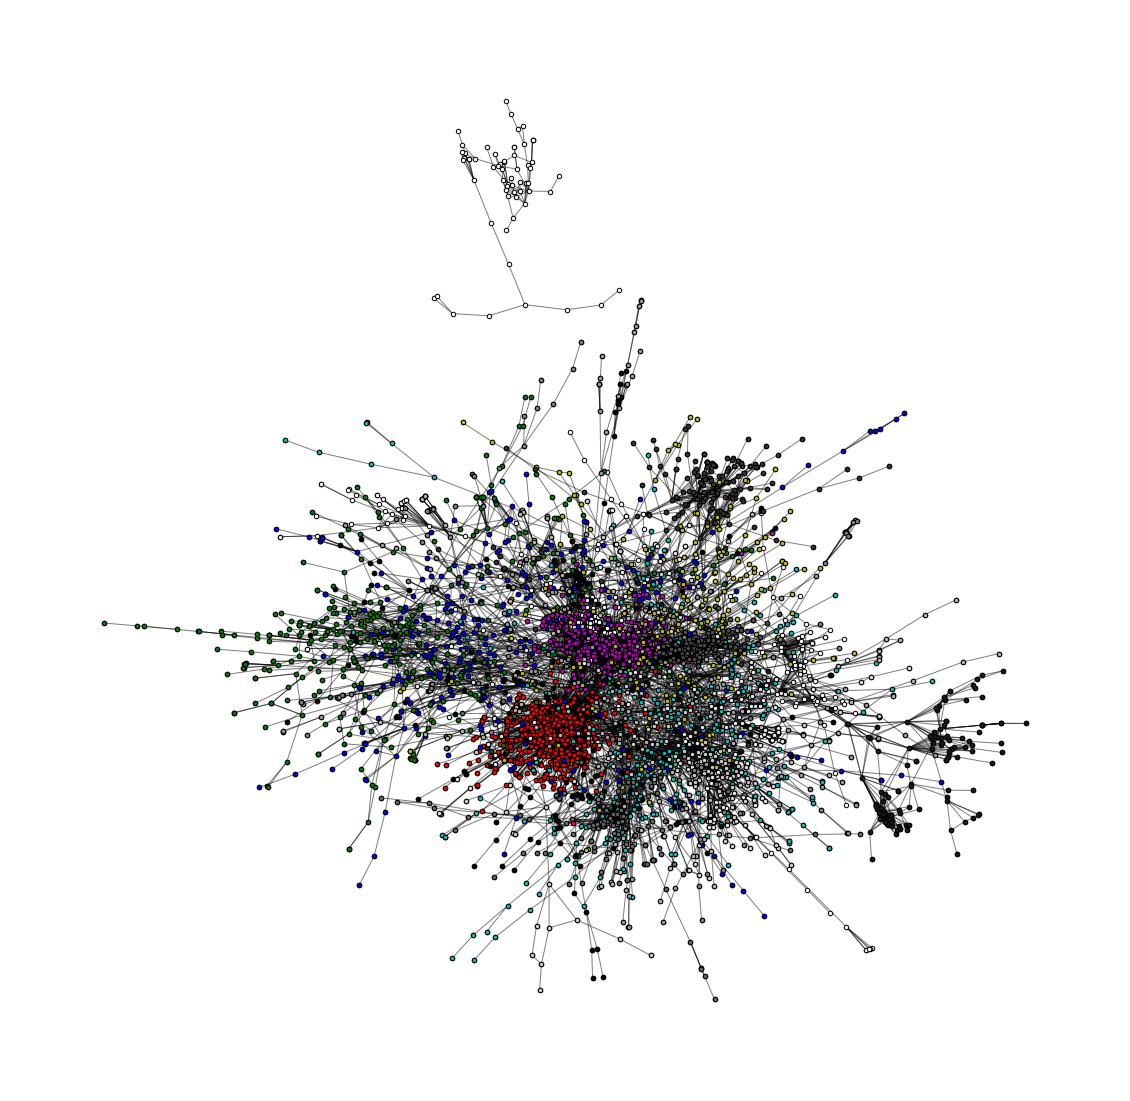

In [27]:
# vizualise the obtained partitions (top 20 communities)
viz.plot_network_clusters(G, coms, node_size=20, figsize=(20, 20), plot_labels=False, top_k=20)

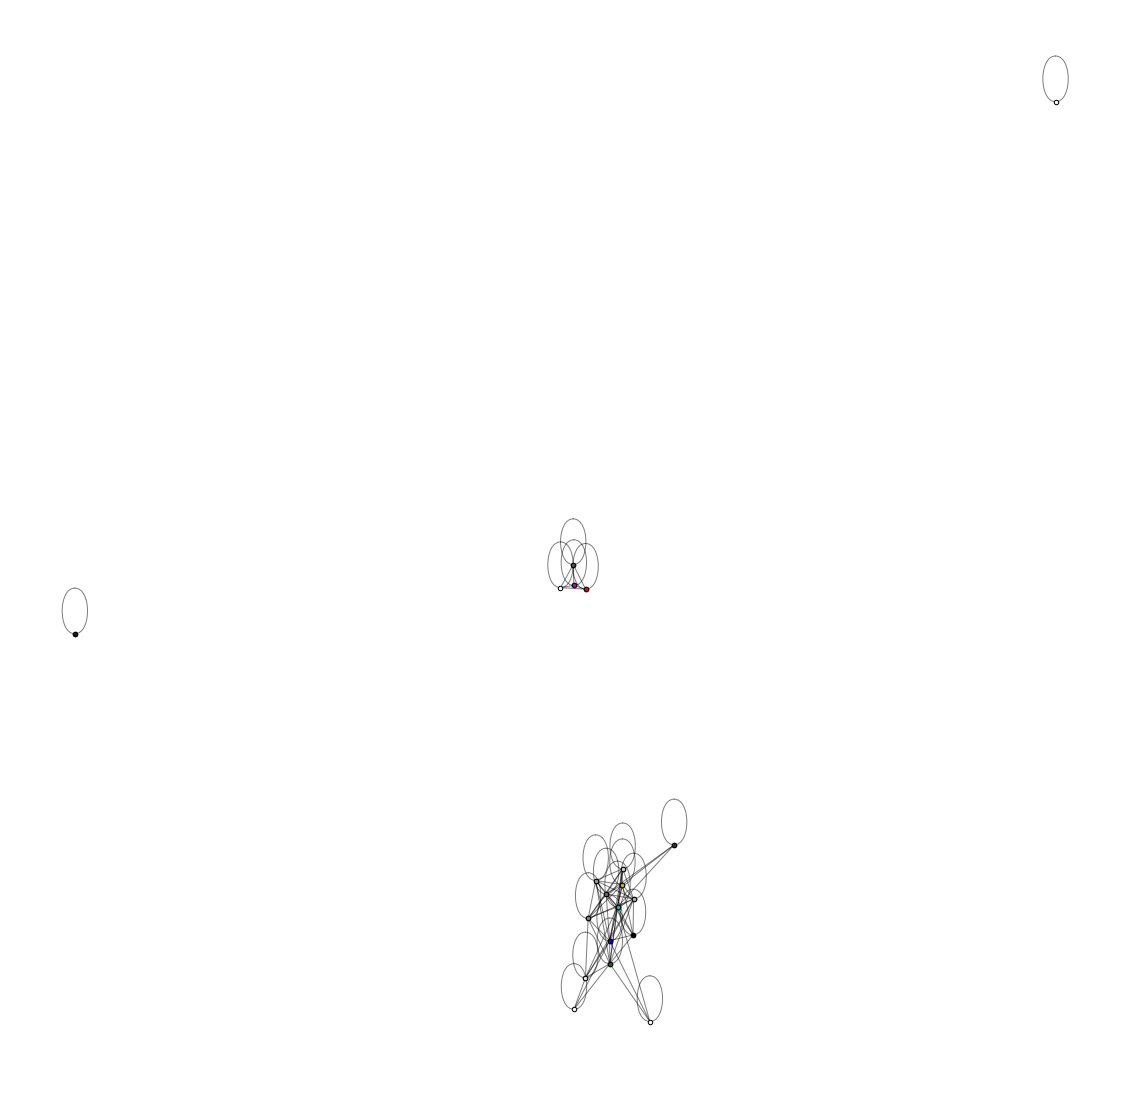

In [28]:
viz.plot_community_graph(G, coms, node_size=20, figsize=(20, 20), plot_labels=False, top_k=20)

This is a nice visualization but didn't show us much more as the graph is very dense. <br>
A 3D one would be much better. We used the pyvis tool which is much nicer but didn't allow us to show communities

In [29]:
# g = net.Network(notebook = True)
# g.from_nx(G)
# g.show("example.html")

## 3.4 Analysing subnetworks

If we aim to see tendencies between those subgroup, we'll need to add features to nodes.

In [30]:
for n in G.nodes:
    G.nodes[n]['actor_gender'] = character_metadata[character_metadata.Freebase_actor_ID == n]['actor_gender'].iloc[0]
    G.nodes[n]['Actor_ethnicity'] = character_metadata[character_metadata.Freebase_actor_ID == n]['Actor_ethnicity'].iloc[0]

We can now compute the assortativity  for certains properties. It measures the similarity of connections in the graph with respect to the given attribute.

In [50]:
print("gender assortativity: ", nx.attribute_assortativity_coefficient(G, 'actor_gender'))
print("ethnicity assortativity: ", nx.attribute_assortativity_coefficient(G, 'Actor_ethnicity'))

gender assortativity:  nan
ethnicity assortativity:  nan


In [32]:
# store the top 20 communities in dataframes
# each row in the dataframe is an actor in the community, the connectivity column represents the total weight of the edges that the actor is connected to
# i.e the total number of movies the actor acted in with the other actors in the community
top_20_communities = []
for i, subgraph in enumerate(subgraphs[:20]):
    top_20_communities.append(pd.DataFrame(subgraph.degree(weight='Number_of_common_movies'), columns=['Actor_name', 'connectivity']).sort_values('connectivity', ascending=False))

In [33]:
# for each community add columns for actors ethnicity, gender and date of birth from the character_metadata dataframe
for i, community in enumerate(top_20_communities):
    top_20_communities[i] = community.merge(character_metadata[['Actor_name','actor_gender', 'Actor_date_of_birth', 'Actor_ethnicity']], on='Actor_name', how='inner').drop_duplicates(subset=['Actor_name']).reset_index(drop=True)
    top_20_communities[i]['community'] = i + 1
top_20_communities_all_actors = pd.concat(top_20_communities).reset_index(drop=True)

In [34]:
G = nx.connected_watts_strogatz_graph(30,5,.2)
nodes = G.nodes()
edges=list(G.edges(data=True))

Additionnally from observing actors in each communities, we would like to include in our communities' analysis the movies within each community, i.e. the movies that connect actors together within a single community. For this purpose, we start by mapping movies' occurencies for each community. 
Later on, we can use this table to analyze the number of movies within each community, whether a movie appears in only one, or several communities, and also add movies features such as genre, length or date of release. 

In [35]:
movies_com_list = pd.DataFrame(columns = ['movie_index','community'])

# first we extract for each edge in a subgraph the corresponding movies and store in a dataframe the movie index and the community
for community_nb in range(1,21):
    for x in subgraphs[community_nb].edges:
        movies = actors_pairs_common_movies_filtered.loc[   (actors_pairs_common_movies_filtered['Freebase_actor_ID_x'] == x[0])
                                                        & (actors_pairs_common_movies_filtered['Freebase_actor_ID_y'] == x[1])].Common_movies
        if len(movies)==0:
            movies = actors_pairs_common_movies_filtered.loc[   (actors_pairs_common_movies_filtered['Freebase_actor_ID_x'] == x[1])
                                                            &  (actors_pairs_common_movies_filtered['Freebase_actor_ID_y'] == x[0])].Common_movies
        if len(movies)==0:
            print('error')
        for liste in movies:
            for elt in liste:
                movies_com_list = movies_com_list.append(pd.DataFrame([[int(elt),int(community_nb)]], columns=['movie_index','community']),ignore_index = True) 

# data rearranged to have each movie as a row, and each community as a column. the value describes the numbers of edges referring to a movie within the specified community
movie_com_table = movies_com_list.pivot_table( columns='community', index='movie_index', aggfunc=len,fill_value=0)
movie_com_table.to_csv('movies_communities_table.csv')

In [36]:
movie_com_table

community,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
movie_index,,,,,,,,,,,,,,,,,,,,
3217,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3333,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3837,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
4231,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4726,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36460235,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
36474734,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
36563324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [37]:
# Aggregate this information with the features of each movie 
movies_com_metadata = pd.merge(movies_metadata, movie_com_table, left_on = 'Wikipedia_movie_ID',right_on = 'movie_index')
movies_com_metadata.to_csv('movies_communities_metadata.csv')
#we still need to clean the Movie_languages, Movie_countries and Movie_genre ? 

## 3.5 Preprocessing of scraped data ( example on an older network of communities )

In [38]:
# load actor dataframe after scraping
actors_scraping = pd.read_csv('top_20_communities_all_actors_wikidata_with_country_occupation.csv')
actors_scraping

,Actor_name,connectivity,actor_gender,Actor_date_of_birth,Actor_ethnicity,Freebase_actor_ID,community,Wikidata_actor_id,actor_country_of_citizenship,actor_occupation
0,John Wayne,286,M,5/26/1907,/m/063k3h,/m/043gj,1,Q40531,United States of America,"['actor', 'film actor', 'film director', 'film..."
1,Roy Rogers,242,M,11/5/1911,/m/07hwkr,/m/01mc6h1,1,Q367129,United States of America,"['television actor', 'film actor', 'singer', '..."
2,George 'Gabby' Hayes,130,M,1885-05-07,NaN,/m/03l6jx,1,Q1277973,United States of America,"['actor', 'television actor', 'film actor', 'r..."
3,Basil Rathbone,121,M,1892-06-13,NaN,/m/0hwd8,1,Q336865,United Kingdom,"['character actor', 'stage actor', 'film actor..."
4,John Carradine,114,M,2/5/1906,NaN,/m/021mlp,1,Q312878,United States of America,"['film actor', 'character actor', 'stage actor..."
...,...,...,...,...,...,...,...,...,...,...
6069,Pushpavalli,3,F,NaN,NaN,/m/080hxfv,20,Q7261853,India,['actor']
6070,Sarathi,3,M,6/26/1942,NaN,/m/0463_8t,20,Q7423331,India,['actor']
6071,Ragini,3,F,1937,NaN,/m/06w4wmq,20,Q7283094,India,['actor']
6072,Nirmalamma,3,F,1920,NaN,/m/07kj3f9,20,Q7040057,India,['actor']


Country of citizenship cleaning 

In [39]:
unique_countries=actors_scraping['actor_country_of_citizenship'].unique()
unique_countries

array(['United States of America', 'United Kingdom', nan, 'Canada',
       'Hungary', 'Mexico', 'Republic of Ireland', 'France',
       'Soviet Union', 'Sweden', 'Romania', 'Kingdom of Romania',
       'United Kingdom of Great Britain and Ireland', 'Portugal',
       'Belgium', 'Dominican Republic', 'Scotland', 'Kingdom of Hungary',
       'Russian Empire', 'Australia', 'Russia', 'Austria', 'Japan',
       'Spain', 'Germany', 'Ottoman Empire', 'Croatia', 'Greece', 'Malta',
       'German Empire', 'Italy', 'Switzerland',
       'Kingdom of the Netherlands', 'Poland', 'England', 'Dominica',
       'New Zealand', 'India', 'British Raj', 'Pakistan', 'Nepal',
       'Sri Lanka', 'Norway', 'Honduras', 'Puerto Rico', 'Philippines',
       'South Africa', 'Wales', 'Egypt', "People's Republic of China",
       'Argentina', 'Colombia', 'Lithuania', 'Armenia', 'Cuba',
       'Venezuela', 'Brazil', 'Panama', 'Nigeria', 'Bhutan', 'Denmark',
       'British Hong Kong', 'Hong Kong', 'Taiwan', 'Singap

We can see that we have some countries that are named in more than way ; Hungary/Kingdom of Hungary , United Kingdom of Great Britain/England/United Kingdom , we tried to use again a sequence matcher but it didn't hold much results , we will have to regroup manually the concerned countires. Old country names such as "Ottoman Empire","Soviet Union","British Raj" have been renamed to their modern names

In [40]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [41]:
matches=[]
for n in unique_countries:
    for x in unique_countries:
        if n!=x:
            match = similar(str(n),str(x))
            if match>0.5:
                matches.append([match,str(n)+' / '+str(x)])
matches[2:10]

[[0.6666666666666666, 'Canada / Panama'],
 [0.56, 'Hungary / Kingdom of Hungary'],
 [0.5777777777777777, "Republic of Ireland / People's Republic of China"],
 [0.7222222222222222, 'Republic of Ireland / Republic of China'],
 [0.6, 'Soviet Union / Slovenia'],
 [0.56, 'Romania / Kingdom of Romania'],
 [0.5714285714285714, 'Romania / Croatia'],
 [0.6666666666666666, 'Romania / Dominica']]

In [42]:
unique_countries

array(['United States of America', 'United Kingdom', nan, 'Canada',
       'Hungary', 'Mexico', 'Republic of Ireland', 'France',
       'Soviet Union', 'Sweden', 'Romania', 'Kingdom of Romania',
       'United Kingdom of Great Britain and Ireland', 'Portugal',
       'Belgium', 'Dominican Republic', 'Scotland', 'Kingdom of Hungary',
       'Russian Empire', 'Australia', 'Russia', 'Austria', 'Japan',
       'Spain', 'Germany', 'Ottoman Empire', 'Croatia', 'Greece', 'Malta',
       'German Empire', 'Italy', 'Switzerland',
       'Kingdom of the Netherlands', 'Poland', 'England', 'Dominica',
       'New Zealand', 'India', 'British Raj', 'Pakistan', 'Nepal',
       'Sri Lanka', 'Norway', 'Honduras', 'Puerto Rico', 'Philippines',
       'South Africa', 'Wales', 'Egypt', "People's Republic of China",
       'Argentina', 'Colombia', 'Lithuania', 'Armenia', 'Cuba',
       'Venezuela', 'Brazil', 'Panama', 'Nigeria', 'Bhutan', 'Denmark',
       'British Hong Kong', 'Hong Kong', 'Taiwan', 'Singap

In [43]:
# Merge all countries into unique key countries
countries_wordsets = dict([
    ('United Kingdom', ['United Kingdom of Great Britain and Ireland', 'Scotland', 'England', 'Wales']),
    ('Ireland', ['Republic of Ireland']),
    ('Russia', ['Soviet Union', 'Russian Empire']),
    ('Romania', ['Kingdom of Romania']),
    ('Hungary', ['Kingdom of Hungary']),
    ('China', ['Republic of China', 'People\'s Republic of China']),
    ('Italy', ['Kingdom of Italy']),
    ('Hong Kong', ['British Hong Kong']),
    ('India', ['British Raj']),
    ('Germany', ['German Empire']),
    ('Turkey', ['Ottoman Empire'])
])

Occupation preprocessing

In [44]:
# 
list_occupations=list(actors_scraping['actor_occupation'])
# Function that extracts occupations from string of occupations
def extract_occupation(string):
    occupation_list=""
    if isinstance(string,str):
        string=string.replace("'", "")
        string=string.replace("[", "")
        string=string.replace("]", "")
        occupation_list = string.split(",")
    
    return occupation_list
occupations_with_dupilicate=[]
for s in list_occupations:
    split_string=extract_occupation(s)
    split_string = [x.strip() for x in split_string]
    occupations_with_dupilicate.append(split_string)

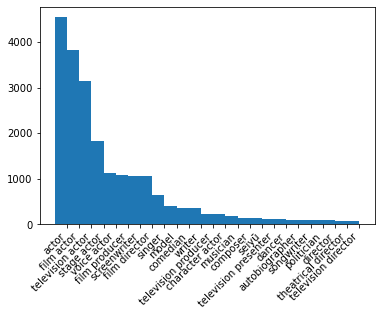

In [45]:
# occupations_unique =  Counter({x for x in occupations_with_dupilicate for x in l})
occupations_unique =  Counter([item for sublist in occupations_with_dupilicate for item in sublist])
top_20_occupations = occupations_unique.most_common(25)

labels = [i[0] for i in top_20_occupations]
values = [i[1] for i in top_20_occupations]
indexes  = np.arange(len(top_20_occupations))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.xticks(rotation=45, ha='right')
plt.show()

In [46]:
occupations_unique.most_common(50)

[('actor', 4544),
 ('film actor', 3827),
 ('television actor', 3148),
 ('stage actor', 1827),
 ('voice actor', 1137),
 ('film producer', 1074),
 ('screenwriter', 1059),
 ('film director', 1052),
 ('singer', 654),
 ('model', 401),
 ('comedian', 362),
 ('writer', 349),
 ('television producer', 237),
 ('character actor', 225),
 ('musician', 182),
 ('composer', 131),
 ('seiyū', 130),
 ('television presenter', 118),
 ('dancer', 109),
 ('autobiographer', 103),
 ('songwriter', 93),
 ('politician', 88),
 ('director', 86),
 ('theatrical director', 81),
 ('television director', 78),
 ('recording artist', 70),
 ('dub actor', 68),
 ('singer-songwriter', 68),
 ('manufacturer', 62),
 ('radio personality', 60),
 ('stunt performer', 48),
 ('film editor', 48),
 ('playwright', 47),
 ('beauty pageant contestant', 45),
 ('journalist', 44),
 ('businessperson', 42),
 ('stand-up comedian', 37),
 ('guitarist', 37),
 ('author', 36),
 ('novelist', 34),
 ('rapper', 34),
 ('painter', 33),
 ('executive producer', 

In [47]:
# Merge all occupations into unique key occupations
occupation_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('actor', ['actor', 'film actor', 'television actor', 'stage actor', 'child actor']),
    ('voice actor', ['voice actor', 'dub actor']),
    ('director', ['director', 'film director', 'theatrical director', 'television director']),
    ('musician', ['singer', 'musician', 'yodeler', 'songwriter', 'rapper',
                               "guitarist", "recording artist", "record producer", "singer-songwriter", 'jazz musician', 'im', 'ive']),
    ('producer', ['producer', 'film producer', 'television producer', 'film editor', 'rapper',
                               "guitarist"]),
    ('writer', ['screenwriter', 'novelist', 'author', 'playwright', 'writer',
                             "autobiographer"]),
    ('dancer', ['dancer', 'ballet dancer']),
    ('model', ['model', 'beauty pageant contestant']),
    ('athlete', ['American football player', 'stunt performer', 'athlete']),
    ('presenter', ['radio personality', 'presenter']),
    ('artist', ['painter', 'sculptor', 'poet', 'painter']),
    ('politician', ['military officer', 'military personnel', 'politician']),
    ('comedian', ['comedian', 'stand-up comedian', 'podcaster']),
    ('businessperson', ['businessman','businesswoman', 'businessperson', 'entrepreneur'])
    ,
    ('journalist', ['journalist'])
])
# A finir 

Analyse Aziz

In [48]:
df_feature_distribution = pd.DataFrame(columns=['Community','Males','Females','1st_country','2nd_country','3rd_country','1st_occupation','2nd_occupation','3rd_occupation'])
for i in range(1, 20):
    df=actors_scraping[actors_scraping['community']==i]
    gender_distribution=df['actor_gender'].value_counts(normalize=True) * 100
    country_distribution=df['actor_country_of_citizenship'].value_counts(normalize=True)
    occupation_distribution=df['actor_occupation'].value_counts(normalize=True)
    print("Community",i,":")
    print("Males=",gender_distribution.M,"%,Females=",gender_distribution.F)
    print(country_distribution[:3].to_string())
    print(occupation_distribution[:3].to_string())

df_feature_distribution

Community 1 :
Males= 67.68916155419224 %,Females= 32.31083844580777
United States of America    0.801036
United Kingdom              0.093264
Canada                      0.033161
['actor', 'film actor']                        0.064050
['actor', 'television actor', 'film actor']    0.041322
['actor']                                      0.040289
Community 2 :
Males= 59.33147632311978 %,Females= 40.66852367688023
India             0.933657
British Raj       0.035599
United Kingdom    0.012945
['actor']                        0.254717
['actor', 'television actor']    0.149371
['actor', 'film actor']          0.033019
Community 3 :
Males= 67.31107205623901 %,Females= 32.68892794376098
United States of America    0.900722
Canada                      0.041516
United Kingdom              0.032491
['voice actor', 'actor']                        0.017986
['actor', 'television actor', 'voice actor']    0.016187
['actor', 'film actor']                         0.012590
Community 4 :
Males= 71.9081

,Community,Males,Females,1st_country,2nd_country,3rd_country,1st_occupation,2nd_occupation,3rd_occupation


Analyse Solene:
Erreur ici je n'ai pas compris pourquoi ça ne run pas ici

In [49]:
all_actors_communities
df = top_20_communities_all_actors.groupby('community')

df_fill = df.agg('count')
#df_fill[['connectivity','actor_gender','Actor_date_of_birth','Actor_ethnicity']]/4
df_fill['actor_gender'] = df_fill.apply(lambda r: r.actor_gender/r.Actor_name*100,axis = 1)
df_fill['connectivity'] = df_fill.apply(lambda r: r.connectivity /r.Actor_name*100,axis = 1)
df_fill['Actor_date_of_birth'] = df_fill.apply(lambda r: r.Actor_date_of_birth/r.Actor_name*100,axis = 1)
df_fill['Actor_ethnicity'] = df_fill.apply(lambda r: r.Actor_ethnicity/r.Actor_name*100,axis = 1)
df_fill

# gender is always here
# date of birth never less than 70%
# ethnicity very small representation (no more than 60% values)

NameError: name 'all_actors_communities' is not defined